In [1]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import config

from tokenizer import ByteLevelBPE

import math

/home/nad/studies/Transformer-Image-Captioning-IIW/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# attn_mask: If specified, a 2D or 3D mask preventing attention to certain positions. Must be of shape
#                 :math:`(L, S)` or :math:`(N\cdot\text{num\_heads}, L, S)`, where :math:`N` is the batch size,
#                 :math:`L` is the target sequence length, and :math:`S` is the source sequence length. A 2D mask will be
#                 broadcasted across the batch while a 3D mask allows for a different mask for each entry in the batch.
#                 Binary and float masks are supported. For a binary mask, a ``True`` value indicates that the
#                 corresponding position is not allowed to attend. For a float mask, the mask values will be added to
#                 the attention weight.

In [3]:
# CPTR paper
def create_mask(seq_length, verbose=False):
    mask = torch.tril(torch.ones((seq_length, seq_length)))  #(1)
    mask[mask == 0] = -float('inf')  #(2)
    mask[mask == 1] = 0  #(3)
    if verbose:
        print('Reference causal mask shape:', mask.shape)
        plt.imshow(mask.cpu(), cmap='gray', aspect='auto')
        plt.title('Reference Causal Mask (White = Blocked, Black = Allowed)')
        plt.xlabel('Sequence Length')
        plt.ylabel('Sequence Length')
        plt.show()
    return mask

# mine

# size: (seq_len, seq_len)
def get_causal_mask(seq_len, device='cpu', verbose=False):
    attn_mask = torch.triu(torch.ones((seq_len, seq_len), device=device, requires_grad=False), diagonal=1).bool()  # Upper triangular matrix
    if verbose:
        print('Causal mask shape:', attn_mask.shape)
        # visualize the mask in matplotlib
        plt.imshow(attn_mask.cpu(), cmap='gray', aspect='auto')
        plt.title('Causal Mask (White = Blocked, Black = Allowed)')
        plt.xlabel('Sequence Length')
        plt.ylabel('Sequence Length')
        plt.show()
    return attn_mask

Causal mask shape: torch.Size([10, 10])


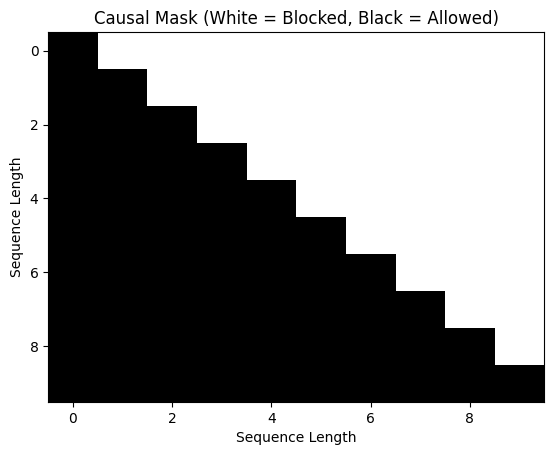

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])
torch.bool
Reference causal mask shape: torch.Size([10, 10])


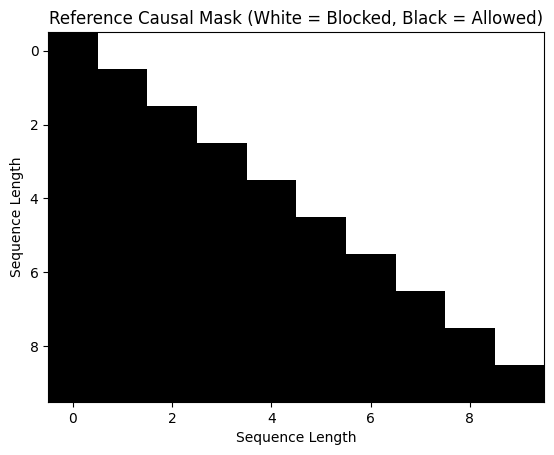

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.float32


In [4]:
seq_len = 10

attn_mask = get_causal_mask(seq_len, device='cpu', verbose=True)
print(attn_mask)  # Print the mask tensor
print(attn_mask.dtype)

# CPTR paper
attn_mask = create_mask(seq_length=seq_len, verbose=True)
print(attn_mask)  # Print the mask tensor
print(attn_mask.dtype)

In [5]:
# key_padding_mask: If specified, a mask of shape :math:`(N, S)` indicating which elements within ``key``
#                 to ignore for the purpose of attention (i.e. treat as "padding"). For unbatched `query`, shape should be :math:`(S)`.
#                 Binary and float masks are supported.
#                 For a binary mask, a ``True`` value indicates that the corresponding ``key`` value will be ignored for
#                 the purpose of attention. For a float mask, it will be directly added to the corresponding ``key`` value.

In [6]:
#                 If both attn_mask and key_padding_mask are supplied, their types should match.

In [7]:
# shape: (batch_size, seq_len)
def get_padding_mask(decoder_inputs, pad_idx, device='cpu', verbose=False):
    pad_mask = torch.zeros(decoder_inputs.size(0), decoder_inputs.size(1), dtype=torch.bool, device=device, requires_grad=False)
    pad_mask[(decoder_inputs == pad_idx)] = True
    if verbose:
        print('Padding mask shape:', pad_mask.shape)
        # visualize the mask in matplotlib
        plt.imshow(pad_mask.cpu(), cmap='gray', aspect='auto')
        plt.title('Padding Mask (White = Blocked, Black = Allowed)')
        plt.xlabel('Sequence Length')
        plt.ylabel('Batch Size')
        plt.show()
    return pad_mask

Padding mask shape: torch.Size([2, 10])


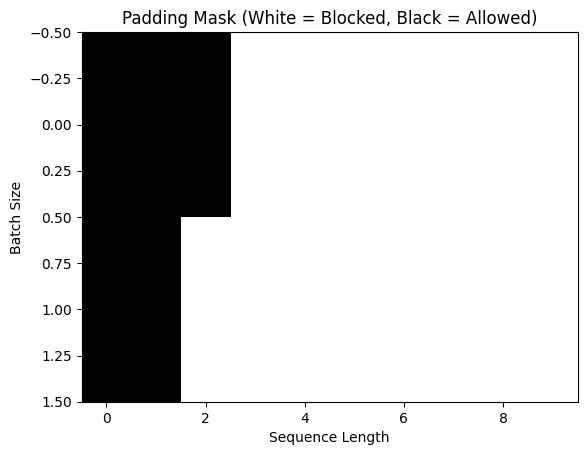

tensor([[False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True]])
torch.bool


In [8]:
mask = get_padding_mask(torch.tensor([[1,2,3,0,0,0,0,0,0,0],[4,5,0,0,0,0,0,0,0,0]]), pad_idx=0, device='cpu', verbose=True)
print(mask)  # Print the mask tensor
print(mask.dtype)

In [9]:
# CPTR paper
class Patcher_(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #(1)
        self.unfold = torch.nn.Unfold(kernel_size=config.PATCH_SIZE, stride=config.PATCH_SIZE)

        #(2)
        self.linear_projection = torch.nn.Linear(in_features=config.NUM_INPUT_CHANNELS*config.PATCH_SIZE*config.PATCH_SIZE, 
                                           out_features=config.EMBEDDING_DIM)
        
    def forward(self, images):
        print(f'images\t\t: {images.size()}')
        
        images = self.unfold(images)  #(3)
        print(f'after unfold\t: {images.size()}')
        
        images = images.permute(0, 2, 1)  #(4)
        print(f'after permute\t: {images.size()}')
        
        features = self.linear_projection(images)  #(5)
        print(f'after lin proj\t: {features.size()}')
        
        return features

# mine
class Patcher(torch.nn.Module):
    def __init__(self, patch_size=config.PATCH_SIZE, channels=config.NUM_INPUT_CHANNELS, emb_dim=config.IMG_EMBEDDING_DIM, bias=config.USE_BIAS):
        super(Patcher, self).__init__()
        self.P = patch_size
        self.C = channels
        self.D = emb_dim
        
        self.patcher = torch.nn.Unfold(kernel_size=self.P, stride=self.P)
        self.linear_embedding = torch.nn.Linear(in_features=self.P*self.P*self.C, out_features=self.D, bias=bias)
    
    def forward(self, images):
        print(f'Input images shape: {images.shape}')
        if images.ndim < 4:
            images = images.unsqueeze(0)
        
        print(f'After unfold: ', self.patcher(images).shape)
        patches = self.patcher(images).permute(0, 2, 1)  # shape: (batch, num_patches, P*P*C)
        print(f'After permute: {patches.shape}')
        patches = self.linear_embedding(patches)  # shape: (batch, num_patches, D)
        print(f'After linear proj: {patches.shape}')
        return patches
    
    def get_linear_weights(self):
        return self.linear_embedding.weight
    

class ConvPatcher(torch.nn.Module):
    def __init__(self, patch_size=config.PATCH_SIZE, channels=config.NUM_INPUT_CHANNELS, emb_dim=config.IMG_EMBEDDING_DIM, bias=config.USE_BIAS, visualize_patches=False):
        super(ConvPatcher, self).__init__()
        self.P = patch_size
        self.C = channels
        self.D = emb_dim
        self.visualize = visualize_patches

        self.conv = torch.nn.Conv2d(in_channels=self.C, out_channels=self.D, kernel_size=self.P, stride=self.P, bias=bias, padding=0)

    def visualize_patches(self, convs, num=5):
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
        
        # Plot random image feature maps
        random_indexes = random.sample(range(0, self.D), k=num) # pick 5 numbers between 0 and the embedding size
        for i, idx in enumerate(random_indexes):
            image_conv_feature_map = convs[0, idx, :, :].squeeze().detach().cpu().numpy() # index on the output tensor of the convolutional layer
            axs[i].imshow(image_conv_feature_map, cmap='twilight')
            axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        plt.show()
    
    def forward(self, images):
        if images.ndim < 4:
            images = images.unsqueeze(0)
        
        # embedding dimension D becomes the number of output feature maps
        patches = self.conv(images)  # shape: (batch_size, embedding_dim, feature_map_height, feature_map_width)
        if self.visualize:
            self.visualize_patches(patches, num=5)
        patches = patches.reshape(patches.shape[0], patches.shape[1], -1)  # shape: (batch_size, embedding_dim, num_patches)
        patches = patches.permute(0, 2, 1)
        print(f'After conv proj: {patches.shape}')
        return patches

images		: torch.Size([16, 3, 224, 224])
after unfold	: torch.Size([16, 768, 196])
after permute	: torch.Size([16, 196, 768])
after lin proj	: torch.Size([16, 196, 768])
Input images shape: torch.Size([16, 3, 224, 224])
After unfold:  torch.Size([16, 768, 196])
After permute: torch.Size([16, 196, 768])
After linear proj: torch.Size([16, 196, 768])


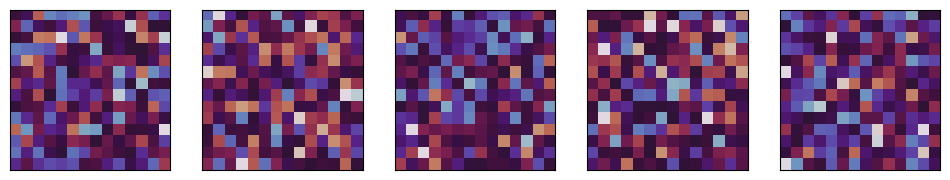

After conv proj: torch.Size([16, 196, 768])


In [10]:
patcher  = Patcher_()

images   = torch.randn(config.BATCH_SIZE_TRAIN, config.NUM_INPUT_CHANNELS, config.IMG_HEIGHT, config.IMG_WIDTH)
features = patcher(images)

patcher = Patcher()
features = patcher(images)

patcher = ConvPatcher(visualize_patches=True)
features = patcher(images)

In [11]:
# CPTR paper
class LearnableEmbedding(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.learnable_embedding = torch.nn.Parameter(torch.randn(size=(config.NUM_PATCHES, config.EMBEDDING_DIM)), 
                                                requires_grad=True)
        
    def forward(self):
        pos_embed = self.learnable_embedding
        print(f'learnable embedding\t: {pos_embed.size()}')
        
        return pos_embed


class LearnablePositionalEmbedding(torch.nn.Module):
    def __init__(self, num_patches=config.NUM_PATCHES, emb_dim=config.IMG_EMBEDDING_DIM):
        super(LearnablePositionalEmbedding, self).__init__()
        self.pos_embedding = torch.nn.Parameter(requires_grad=True, data=torch.randn(size=(1, num_patches, emb_dim)))

    def forward(self):
        print(f'learnable embedding\t: {self.pos_embedding.size()}')
        return self.pos_embedding

In [12]:
emb = LearnableEmbedding()
pos_embed = emb()

emb = LearnablePositionalEmbedding()
pos_embed = emb()

learnable embedding	: torch.Size([196, 768])
learnable embedding	: torch.Size([1, 196, 768])


In [13]:
# CPTR paper
class EncoderBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.self_attention = torch.nn.MultiheadAttention(embed_dim=config.IMG_EMBEDDING_DIM,
                                                    num_heads=config.ENCODER_NUM_HEADS, 
                                                    batch_first=True,  #(2)
                                                    dropout=config.ENCODER_DROPOUT_PROB)
        
        self.layer_norm_0 = torch.nn.LayerNorm(config.IMG_EMBEDDING_DIM)  #(3)
        self.ffn = torch.nn.Sequential(  #(4)
            torch.nn.Linear(in_features=config.IMG_EMBEDDING_DIM, out_features=config.ENCODER_HIDDEN_DIM),
            torch.nn.GELU(), 
            torch.nn.Dropout(p=config.ENCODER_DROPOUT_PROB), 
            torch.nn.Linear(in_features=config.ENCODER_HIDDEN_DIM, out_features=config.IMG_EMBEDDING_DIM),
        )
        self.layer_norm_1 = torch.nn.LayerNorm(config.IMG_EMBEDDING_DIM)  #(5)
        
# Codeblock 7b
    def forward(self, features):  #(1)
        residual = features  #(2)
        print(f'features & residual\t: {residual.size()}')
        
        features, self_attn_weights = self.self_attention(query=features, 
                                                          key=features, 
                                                          value=features)
        print(f'after self attention\t: {features.size()}')
        print(f"self attn weights\t: {self_attn_weights.shape}")
        
        features = self.layer_norm_0(features + residual)  #(4)
        print(f'after norm\t\t: {features.size()}')
        
        residual = features
        print(f'\nfeatures & residual\t: {residual.size()}')
        
        features = self.ffn(features)  #(5)
        print(f'after ffn\t\t: {features.size()}')
        
        features = self.layer_norm_1(features + residual)
        print(f'after norm\t\t: {features.size()}')
        
        return features

class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.patcher = Patcher()  #(1)
        self.learnable_embedding = LearnableEmbedding()  #(2)

        self.encoder_blocks = torch.nn.ModuleList(EncoderBlock() for _ in range(config.ENCODER_NUM_BLOCKS))
    
    def forward(self, images):  #(4)
        print(f'images\t\t\t: {images.size()}')
        
        features = self.patcher(images)  #(5)
        print(f'after patcher\t\t: {features.size()}')
        
        features = features + self.learnable_embedding()  #(6)
        print(f'after learn embed\t: {features.size()}')
        
        for i, encoder_block in enumerate(self.encoder_blocks):
            features = encoder_block(features)  #(7)
            print(f"after encoder block #{i}\t: {features.shape}")

        return features

In [14]:
encoder = Encoder()
images  = torch.randn(config.BATCH_SIZE_TRAIN, config.NUM_INPUT_CHANNELS, config.IMG_HEIGHT, config.IMG_WIDTH)
output = encoder(images)

images			: torch.Size([16, 3, 224, 224])
Input images shape: torch.Size([16, 3, 224, 224])
After unfold:  torch.Size([16, 768, 196])
After permute: torch.Size([16, 196, 768])
After linear proj: torch.Size([16, 196, 768])
after patcher		: torch.Size([16, 196, 768])
learnable embedding	: torch.Size([196, 768])
after learn embed	: torch.Size([16, 196, 768])
features & residual	: torch.Size([16, 196, 768])
after self attention	: torch.Size([16, 196, 768])
self attn weights	: torch.Size([16, 196, 196])
after norm		: torch.Size([16, 196, 768])

features & residual	: torch.Size([16, 196, 768])
after ffn		: torch.Size([16, 196, 768])
after norm		: torch.Size([16, 196, 768])
after encoder block #0	: torch.Size([16, 196, 768])
features & residual	: torch.Size([16, 196, 768])
after self attention	: torch.Size([16, 196, 768])
self attn weights	: torch.Size([16, 196, 196])
after norm		: torch.Size([16, 196, 768])

features & residual	: torch.Size([16, 196, 768])
after ffn		: torch.Size([16, 196, 76

In [15]:
# mine
class EncoderBlock(torch.nn.Module):
    def __init__(self, embed_dim=config.IMG_EMBEDDING_DIM, num_heads=config.ENCODER_NUM_HEADS, hidden_dim=config.ENCODER_HIDDEN_DIM, dropout_prob=config.ENCODER_DROPOUT_PROB, bias=config.USE_BIAS, sublayer_dropout=config.SUBLAYER_DROPOUT):
        super(EncoderBlock, self).__init__()
        self.MHSA = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True, dropout=dropout_prob, bias=bias)
        self.layer_norm_1 = torch.nn.LayerNorm(embed_dim)
        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, hidden_dim, bias=bias),
            torch.nn.GELU(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(hidden_dim, embed_dim, bias=bias)
        )
        self.layer_norm_2 = torch.nn.LayerNorm(embed_dim)
        
        if sublayer_dropout:
            self.sublayer_dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, x):
        residual = x
        print(f'features & residual\t: {x.size()}')
        
        attn_output, weights = self.MHSA(query=x, key=x, value=x)
        
        print(f'after self attention\t: {attn_output.size()}')
        print(f"self attn weights\t: {weights.shape}")
        
        if hasattr(self, 'sublayer_dropout'):
            attn_output = self.sublayer_dropout(attn_output)
            print(f'after sublayer dropout\t: {attn_output.size()}')
        
        assert residual is x  # just to use residual variable and avoid linter warning
        x = self.layer_norm_1(x + attn_output)
        print(f'after norm\t\t: {x.size()}')
        
        residual = x
        print(f'\nfeatures & residual\t: {x.size()}')

        ff_output = self.FFN(x)
        print(f'after ffn\t\t: {ff_output.size()}')
        
        assert residual is x  # just to use residual variable and avoid linter warning
        x = self.layer_norm_2(x + ff_output)
        print(f'after norm\t\t: {x.size()}')
        
        return x

# takes patches after linear projection and positional encoding
class Encoder(torch.nn.Module):
    def __init__(self, num_blocks=config.ENCODER_NUM_BLOCKS, embed_dim=config.IMG_EMBEDDING_DIM, num_heads=config.ENCODER_NUM_HEADS, hidden_dim=config.ENCODER_HIDDEN_DIM, dropout_prob=config.ENCODER_DROPOUT_PROB, bias=config.USE_BIAS, sublayer_dropout=config.SUBLAYER_DROPOUT):
        super(Encoder, self).__init__()
        self.encoder_blocks = torch.nn.ModuleList()
        for _ in range(num_blocks):
            self.encoder_blocks.append(EncoderBlock(embed_dim=embed_dim, num_heads=num_heads, hidden_dim=hidden_dim, dropout_prob=dropout_prob, bias=bias, sublayer_dropout=sublayer_dropout))

    def forward(self, x):
        for block in self.encoder_blocks:
            x = block(x)
            print(f'after encoder block\t: {x.size()}')
        return x

In [16]:
patcher = ConvPatcher()
img_pos_embedding = LearnablePositionalEmbedding()
encoder = Encoder()
patches = patcher(images)
print(f'after patcher\t\t: {patches.size()}')
pos_emb = img_pos_embedding()
emb = patches + pos_emb
print(f'after learnable emb\t: {emb.size()}')
output2 = encoder(emb)

After conv proj: torch.Size([16, 196, 768])
after patcher		: torch.Size([16, 196, 768])
learnable embedding	: torch.Size([1, 196, 768])
after learnable emb	: torch.Size([16, 196, 768])
features & residual	: torch.Size([16, 196, 768])
after self attention	: torch.Size([16, 196, 768])
self attn weights	: torch.Size([16, 196, 196])
after sublayer dropout	: torch.Size([16, 196, 768])
after norm		: torch.Size([16, 196, 768])

features & residual	: torch.Size([16, 196, 768])
after ffn		: torch.Size([16, 196, 768])
after norm		: torch.Size([16, 196, 768])
after encoder block	: torch.Size([16, 196, 768])
features & residual	: torch.Size([16, 196, 768])
after self attention	: torch.Size([16, 196, 768])
self attn weights	: torch.Size([16, 196, 196])
after sublayer dropout	: torch.Size([16, 196, 768])
after norm		: torch.Size([16, 196, 768])

features & residual	: torch.Size([16, 196, 768])
after ffn		: torch.Size([16, 196, 768])
after norm		: torch.Size([16, 196, 768])
after encoder block	: torc

In [17]:
# compare encoders outputs by computing mean and std
mean_output = output.mean().item()
std_output = output.std().item()
mean_output2 = output2.mean().item()
std_output2 = output2.std().item()
print(f"Encoder Output 1 - mean: {mean_output}, std: {std_output}")
print(f"Encoder Output 2 - mean: {mean_output2}, std: {std_output2}")

Encoder Output 1 - mean: 6.335527588663403e-12, std: 0.9999954104423523
Encoder Output 2 - mean: 5.606942132807546e-10, std: 0.9999954104423523


In [18]:
# CPTR paper
class SinusoidalEmbedding(torch.nn.Module):
    def forward(self, seq_len=config.MAX_TEXT_SEQUENCE_LENGTH):
        pos = torch.arange(seq_len).reshape(seq_len, 1)
        #print(f"pos\t\t: {pos.shape}")
        
        i = torch.arange(0, config.EMBEDDING_DIM, 2)
        denominator = torch.pow(10000, i/config.EMBEDDING_DIM)
        #print(f"denominator\t: {denominator.shape}")
        
        even_pos_embed = torch.sin(pos/denominator)  #(1)
        odd_pos_embed  = torch.cos(pos/denominator)  #(2)
        #print(f"even_pos_embed\t: {even_pos_embed.shape}")
        
        stacked = torch.stack([even_pos_embed, odd_pos_embed], dim=2)  #(3)
        #print(f"stacked\t\t: {stacked.shape}")

        pos_embed = torch.flatten(stacked, start_dim=1, end_dim=2)  #(4)
        #print(f"pos_embed\t: {pos_embed.shape}")
        
        return pos_embed

# mine
class SinusoidPositionalEncoding(torch.nn.Module):
    def __init__(self,
        max_seq_len=config.MAX_TEXT_SEQUENCE_LENGTH,
        emb_dim=config.TEXT_EMBEDDING_DIM
    ):
        super().__init__()
        # create the positional encoding tensor of shape
        # maximum sequence length (L) by embedding dimension (D)
        pe = torch.zeros(max_seq_len, emb_dim, dtype=torch.float)

        # positions indexes: [0, 1, 2, ..., max_seq_len-1], with shape (L, 1)
        position = torch.arange(max_seq_len).unsqueeze(1)
        # frequency division terms with shape (D/2,) or (1, D/2)
        # use log for numerical stability: a**b = exp(b * log(a))
        div_term = torch.exp(
            torch.arange(0, emb_dim, 2) * (-math.log(10000) / emb_dim)
        )

        # even positional encodings use sine, odd cosine
        # matrix-slice shape: (L, D/2), resulting matrix shape: (L, D)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Buffers are for tensors that are not learnable parameters (no gradients) but are still part of the model's state
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)

    def forward(self, x: torch.Tensor):
        # For regular inference, we don't need to pad the embeddings to max_seq_len anymore
        # Retrieve embeddings up to sequence length (S). output shape (1, S, C)
        return self.pe[:, :x.shape[1], :]

In [19]:
seq_len = 10
sinusoidal_embedding = SinusoidalEmbedding()
pos_embed_1 = sinusoidal_embedding(seq_len)
print(f'sinusoidal embedding\t: {pos_embed_1.size()}')
print(pos_embed_1)

sinusoidal_embedding = SinusoidPositionalEncoding()
pos_embed_2 = sinusoidal_embedding(torch.zeros(1, seq_len, config.TEXT_EMBEDDING_DIM))
print(f'sinusoidal embedding\t: {pos_embed_2.size()}')
print(pos_embed_2)

assert torch.allclose(pos_embed_1, pos_embed_2.squeeze(0), atol=1e-6)

sinusoidal embedding	: torch.Size([10, 768])
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2843e-01,  ...,  1.0000e+00,
          1.0243e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.2799e-01,  ...,  1.0000e+00,
          2.0486e-04,  1.0000e+00],
        ...,
        [ 6.5699e-01,  7.5390e-01,  5.2347e-01,  ...,  1.0000e+00,
          7.1699e-04,  1.0000e+00],
        [ 9.8936e-01, -1.4550e-01,  9.9905e-01,  ...,  1.0000e+00,
          8.1942e-04,  1.0000e+00],
        [ 4.1212e-01, -9.1113e-01,  5.9565e-01,  ...,  1.0000e+00,
          9.2185e-04,  1.0000e+00]])
sinusoidal embedding	: torch.Size([1, 10, 768])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2843e-01,  ...,  1.0000e+00,
           1.0243e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.2799e-01,  ...,  1.0000e+0

In [20]:
# CPTR paper
class DecoderBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.self_attention = torch.nn.MultiheadAttention(embed_dim=config.EMBEDDING_DIM, 
                                                    num_heads=config.DECODER_NUM_HEADS, 
                                                    batch_first=True, 
                                                    dropout=config.DECODER_DROPOUT_PROB)
        self.layer_norm_0 = torch.nn.LayerNorm(config.EMBEDDING_DIM)
        self.cross_attention = torch.nn.MultiheadAttention(embed_dim=config.EMBEDDING_DIM, 
                                                     num_heads=config.DECODER_NUM_HEADS, 
                                                     batch_first=True, 
                                                     dropout=config.DECODER_DROPOUT_PROB)
        self.layer_norm_1 = torch.nn.LayerNorm(config.EMBEDDING_DIM)       
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(in_features=config.EMBEDDING_DIM, out_features=config.DECODER_HIDDEN_DIM),
            torch.nn.GELU(), 
            torch.nn.Dropout(p=config.DECODER_DROPOUT_PROB), 
            torch.nn.Linear(in_features=config.DECODER_HIDDEN_DIM, out_features=config.EMBEDDING_DIM),
        )
        self.layer_norm_2 = torch.nn.LayerNorm(config.EMBEDDING_DIM)
        
    def forward(self, features, captions, attn_mask):
        print(f"attn_mask\t\t: {attn_mask.shape}")
        residual = captions
        print(f"captions & residual\t: {captions.shape}")
        
        captions, self_attn_weights = self.self_attention(query=captions, 
                                                          key=captions, 
                                                          value=captions, 
                                                          attn_mask=attn_mask)
        print(f"after self attention\t: {captions.shape}")
        print(f"self attn weights\t: {self_attn_weights.shape}")
        
        captions = self.layer_norm_0(captions + residual)
        print(f"after norm\t\t: {captions.shape}")
        
        print(f"\nfeatures\t\t: {features.shape}")
        residual = captions
        print(f"captions & residual\t: {captions.shape}")
        
        captions, cross_attn_weights = self.cross_attention(query=captions, 
                                                            key=features, 
                                                            value=features)
        print(f"after cross attention\t: {captions.shape}")
        print(f"cross attn weights\t: {cross_attn_weights.shape}")
        
        captions = self.layer_norm_1(captions + residual)
        print(f"after norm\t\t: {captions.shape}")
        
        residual = captions
        print(f"\ncaptions & residual\t: {captions.shape}")
        
        captions = self.ffn(captions)  
        print(f"after ffn\t\t: {captions.shape}")
        
        captions = self.layer_norm_2(captions + residual)
        print(f"after norm\t\t: {captions.shape}")
        
        return captions

class Decoder(torch.nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=config.EMBEDDING_DIM)
        self.sinusoidal_embedding = SinusoidalEmbedding()
        self.decoder_blocks = torch.nn.ModuleList(DecoderBlock() for _ in range(config.DECODER_NUM_BLOCKS))
        self.linear = torch.nn.Linear(in_features=config.EMBEDDING_DIM, 
                                out_features=vocab_size)
        
    def forward(self, features, captions, attn_mask):  #(1)
        print(f"features\t\t: {features.shape}")
        print(f"captions\t\t: {captions.shape}")
        
        captions = self.embedding(captions)  #(2)
        print(f"after embedding\t\t: {captions.shape}")
        
        captions = captions + self.sinusoidal_embedding(captions.shape[1]).to(captions.device)  #(3)
        print(f"after sin embed\t\t: {captions.shape}")
        
        for i, decoder_block in enumerate(self.decoder_blocks):
            captions = decoder_block(features, captions, attn_mask)  #(4)
            print(f"after decoder block #{i}\t: {captions.shape}")
        
        captions = self.linear(captions)  #(5)
        print(f"after linear\t\t: {captions.shape}")
        
        return captions

In [21]:
decoder_block = DecoderBlock()
seq_length = 10
vocab_size = 100

features = torch.randn(config.BATCH_SIZE_TRAIN, config.NUM_PATCHES, config.EMBEDDING_DIM)
captions = torch.randn(config.BATCH_SIZE_TRAIN, seq_length, config.EMBEDDING_DIM)
look_ahead_mask = create_mask(seq_length=seq_length)

decoder_block(features, captions, look_ahead_mask)

attn_mask		: torch.Size([10, 10])
captions & residual	: torch.Size([16, 10, 768])
after self attention	: torch.Size([16, 10, 768])
self attn weights	: torch.Size([16, 10, 10])
after norm		: torch.Size([16, 10, 768])

features		: torch.Size([16, 196, 768])
captions & residual	: torch.Size([16, 10, 768])
after cross attention	: torch.Size([16, 10, 768])
cross attn weights	: torch.Size([16, 10, 196])
after norm		: torch.Size([16, 10, 768])

captions & residual	: torch.Size([16, 10, 768])
after ffn		: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])


tensor([[[-0.1837, -0.7576, -2.7767,  ...,  0.2307,  0.5473,  0.7948],
         [-0.5727,  0.4069, -2.2995,  ..., -1.2037,  0.0416,  1.7350],
         [-1.1595, -0.3293,  0.0287,  ...,  0.9144, -0.4494, -1.6718],
         ...,
         [-0.4221,  1.2612, -1.1061,  ..., -0.1490,  0.4487, -2.0981],
         [ 1.2520,  1.6494,  1.3075,  ...,  2.0961, -0.0689,  0.5034],
         [ 0.9881, -0.9955,  1.2436,  ..., -0.3074, -2.1582,  0.7660]],

        [[-1.0846, -0.1489, -1.2281,  ...,  0.1600, -0.9643, -0.0949],
         [ 0.1687, -0.7035, -0.6381,  ..., -0.2588,  0.7814, -2.3095],
         [-1.4492,  0.5908,  1.9926,  ...,  0.6617, -0.3175, -1.2848],
         ...,
         [-0.6023, -0.0891, -0.0363,  ..., -1.0226, -0.2452, -0.6040],
         [ 1.8762,  0.4930,  1.0663,  ..., -0.8836, -0.5276, -0.3208],
         [-0.1763,  1.3944, -0.2470,  ...,  0.0067,  0.9317, -1.7565]],

        [[-0.6069,  0.0825,  0.0655,  ...,  0.3664, -0.7940, -0.1469],
         [ 0.7718, -1.9250,  1.5158,  ...,  0

In [22]:
decoder = Decoder(vocab_size=vocab_size)

features2 = torch.randn(config.BATCH_SIZE_TRAIN, config.NUM_PATCHES, config.EMBEDDING_DIM)
captions2 = torch.randint(0, vocab_size, (config.BATCH_SIZE_TRAIN, seq_length))  #(1)

logits = decoder(features2, captions2, look_ahead_mask)

features		: torch.Size([16, 196, 768])
captions		: torch.Size([16, 10])
after embedding		: torch.Size([16, 10, 768])
after sin embed		: torch.Size([16, 10, 768])
attn_mask		: torch.Size([10, 10])
captions & residual	: torch.Size([16, 10, 768])
after self attention	: torch.Size([16, 10, 768])
self attn weights	: torch.Size([16, 10, 10])
after norm		: torch.Size([16, 10, 768])

features		: torch.Size([16, 196, 768])
captions & residual	: torch.Size([16, 10, 768])
after cross attention	: torch.Size([16, 10, 768])
cross attn weights	: torch.Size([16, 10, 196])
after norm		: torch.Size([16, 10, 768])

captions & residual	: torch.Size([16, 10, 768])
after ffn		: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])
after decoder block #0	: torch.Size([16, 10, 768])
attn_mask		: torch.Size([10, 10])
captions & residual	: torch.Size([16, 10, 768])
after self attention	: torch.Size([16, 10, 768])
self attn weights	: torch.Size([16, 10, 10])
after norm		: torch.Size([16, 10, 768])

f

In [23]:
# mine
class LearnableWordEmbedding(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim, padding_idx):
        super(LearnableWordEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=padding_idx)
        
    def forward(self, input_ids):
        assert input_ids.dtype == torch.long, f"Input tensor must have dtype torch.long, got {input_ids.dtype}"
        embeddings = self.embedding(input_ids)
        return embeddings

class DecoderBlock(torch.nn.Module):
    def __init__(self, embed_dim=config.EMBEDDING_DIM, num_heads=config.DECODER_NUM_HEADS, hidden_dim=config.DECODER_HIDDEN_DIM, dropout_prob=config.DECODER_DROPOUT_PROB, bias=config.USE_BIAS, sublayer_dropout=config.SUBLAYER_DROPOUT, verbose=False):
        super(DecoderBlock, self).__init__()
        self.MMHSA = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True, dropout=dropout_prob, bias=bias)
        self.layer_norm_1 = torch.nn.LayerNorm(embed_dim)
        # the bridge between the encoder and the decoder, K and V come from encoder, Q is derived from the previous decoder sublayer
        self.MHCA = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True, dropout=dropout_prob / 2, bias=bias)
        self.layer_norm_2 = torch.nn.LayerNorm(embed_dim)
        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, hidden_dim, bias=bias),
            torch.nn.GELU(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(hidden_dim, embed_dim, bias=bias)
        )
        self.layer_norm_3 = torch.nn.LayerNorm(embed_dim)
        if sublayer_dropout:
            self.sublayer_dropout = torch.nn.Dropout(p=dropout_prob)
        self.verbose = verbose
        
        if verbose:
            print(f'DecoderBlock initialized with embed_dim={embed_dim}, num_heads={num_heads}, hidden_dim={hidden_dim}, dropout_prob={dropout_prob}, bias={bias}')

    def forward(self, x, k, v, attn_mask, pad_mask):
        print(f"attn_mask\t\t: {attn_mask.shape}")

        if x.ndim != 3:
            raise ValueError(f'Input tensor x must have 3 dimensions (batch_size, seq_length, embed_dim), but got {x.ndim} dimensions.')
        
        print(f"captions & residual\t: {x.shape}")

        attn_output, mmhsa_w = self.MMHSA(query=x, key=x, value=x, attn_mask=attn_mask, key_padding_mask=pad_mask)
        # print('Masked Multi-Head Self-Attention weights shape:', mmhsa_w.shape)
        
        print(f"after self attention\t: {attn_output.shape}")
        print(f"self attn weights\t: {mmhsa_w.shape}")
        
        if hasattr(self, 'sublayer_dropout'):
            # apply dropout before layer normalization for each sublayer
            attn_output = self.sublayer_dropout(attn_output)
            print(f'after sublayer dropout\t: {attn_output.shape}')
            
        x = self.layer_norm_1(x + attn_output) # TODO: debug cross attention, and text vs img embeddings as inputs
        print(f"after norm\t\t: {x.shape}")

        print(f"\nfeatures\t\t: {k.shape}")
        assert k is v  # just to indicate that k and v are from the encoder output
        print(f"captions & residual\t: {x.shape}")
        
        attn_output, mhca_w = self.MHCA(query=x, key=k, value=v)
        # print('Cross Attention weights shape:', mhca_w.shape)
        
        print(f"after cross attention\t: {attn_output.shape}")
        print(f"cross attn weights\t: {mhca_w.shape}")
        
        if hasattr(self, 'sublayer_dropout'):
            # apply dropout before layer normalization for each sublayer
            attn_output = self.sublayer_dropout(attn_output)
            print(f'after sublayer dropout\t: {attn_output.shape}')
        
        x = self.layer_norm_2(x + attn_output)
        print(f"after norm\t\t: {x.shape}")
        
        ff_output = self.FFN(x)
        print(f"after ffn\t\t: {captions.shape}")
        
        x = self.layer_norm_3(x + ff_output)
        print(f"after norm\t\t: {x.shape}")
        
        # print(f"Cross-attn weights mean: {mhca_w.mean()}, std: {mhca_w.std()}")
        return x

class Decoder(torch.nn.Module):
    def __init__(self, num_blocks=config.DECODER_NUM_BLOCKS, embed_dim=config.EMBEDDING_DIM, num_heads=config.DECODER_NUM_HEADS, hidden_dim=config.DECODER_HIDDEN_DIM, dropout_prob=config.DECODER_DROPOUT_PROB, bias=config.USE_BIAS, sublayer_dropout=config.SUBLAYER_DROPOUT, verbose=False):
        super(Decoder, self).__init__()
        self.decoder_blocks = torch.nn.ModuleList()
        for _ in range(num_blocks):
            self.decoder_blocks.append(DecoderBlock(embed_dim=embed_dim, num_heads=num_heads, hidden_dim=hidden_dim, dropout_prob=dropout_prob, bias=bias, sublayer_dropout=sublayer_dropout, verbose=verbose))

    def forward(self, x, enc_output, attn_mask, pad_mask):
        for block in self.decoder_blocks:
            x = block.forward(x, k=enc_output, v=enc_output, attn_mask=attn_mask, pad_mask=pad_mask)
            print(f"after decoder block\t: {x.shape}")
        return x

In [24]:
decoder_block = DecoderBlock()
seq_length = 10

look_ahead_mask = get_causal_mask(seq_length, device='cpu')

decoder_block(x=captions, k=features, v=features, attn_mask=look_ahead_mask, pad_mask=None)

attn_mask		: torch.Size([10, 10])
captions & residual	: torch.Size([16, 10, 768])
after self attention	: torch.Size([16, 10, 768])
self attn weights	: torch.Size([16, 10, 10])
after sublayer dropout	: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])

features		: torch.Size([16, 196, 768])
captions & residual	: torch.Size([16, 10, 768])
after cross attention	: torch.Size([16, 10, 768])
cross attn weights	: torch.Size([16, 10, 196])
after sublayer dropout	: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])
after ffn		: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])


tensor([[[-3.3416e-01,  3.3404e-01, -2.1292e+00,  ...,  4.2771e-01,
           8.7622e-01,  4.1506e-01],
         [-5.1127e-01,  4.9171e-01, -1.9297e+00,  ..., -1.3645e+00,
          -5.8908e-01,  1.2489e+00],
         [-8.3136e-01, -2.1311e-01,  1.7480e-01,  ...,  9.3618e-01,
          -6.1393e-01, -1.5810e+00],
         ...,
         [-2.1087e-01,  1.0485e+00, -9.2834e-01,  ...,  2.2675e-01,
           3.2850e-01, -2.7942e+00],
         [ 9.6728e-01,  1.8492e+00,  1.1786e+00,  ...,  2.6246e+00,
           8.8281e-02,  2.0738e-01],
         [ 7.1426e-01, -7.3996e-01,  1.4532e+00,  ..., -8.6416e-01,
          -2.5485e+00,  4.4710e-01]],

        [[-3.8362e-01, -6.7436e-01, -7.2990e-01,  ...,  1.2693e-01,
          -5.7018e-01,  9.8554e-01],
         [ 3.4430e-01, -5.1261e-01, -5.3866e-01,  ..., -7.2104e-01,
           5.9544e-01, -1.3046e+00],
         [-1.3354e+00,  5.0809e-01,  1.8878e+00,  ...,  9.6029e-04,
          -2.8837e-01, -7.3275e-01],
         ...,
         [-1.2037e+00,  2

In [25]:
decoder = Decoder()
seq_length = 10
word_embedding = LearnableWordEmbedding(vocab_size=vocab_size, emb_dim=config.EMBEDDING_DIM, padding_idx=0)
text_pos_embedding = SinusoidPositionalEncoding(max_seq_len=seq_length, emb_dim=config.EMBEDDING_DIM)
scaling = float(math.sqrt(config.EMBEDDING_DIM))
text_layernorm = torch.nn.LayerNorm(config.EMBEDDING_DIM)
linear = torch.nn.Linear(in_features=config.EMBEDDING_DIM, out_features=vocab_size, bias=False)

if captions2.ndim < 2:
    captions2 = captions2.unsqueeze(0)
    
print(f"features\t\t: {features2.shape}")
print(f"captions\t\t: {captions2.shape}")
embeddings = word_embedding(captions2) * scaling # (B, L) -> (B, L, D)
print(f"after embedding\t\t: {embeddings.shape}")
emb_sum = text_layernorm(embeddings + text_pos_embedding(embeddings))
print(f"after sin embed\t\t: {emb_sum.shape}")
look_ahead_mask = get_causal_mask(seq_length, device='cpu')
emb_sum = decoder.forward(x=emb_sum, enc_output=features2, attn_mask=look_ahead_mask, pad_mask=None)
print(f"after decoder\t\t: {emb_sum.shape}")
logits2 = linear(emb_sum)
print(f"after linear\t\t: {logits2.shape}")

features		: torch.Size([16, 196, 768])
captions		: torch.Size([16, 10])
after embedding		: torch.Size([16, 10, 768])
after sin embed		: torch.Size([16, 10, 768])
attn_mask		: torch.Size([10, 10])
captions & residual	: torch.Size([16, 10, 768])
after self attention	: torch.Size([16, 10, 768])
self attn weights	: torch.Size([16, 10, 10])
after sublayer dropout	: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])

features		: torch.Size([16, 196, 768])
captions & residual	: torch.Size([16, 10, 768])
after cross attention	: torch.Size([16, 10, 768])
cross attn weights	: torch.Size([16, 10, 196])
after sublayer dropout	: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])
after ffn		: torch.Size([16, 10, 768])
after norm		: torch.Size([16, 10, 768])
after decoder block	: torch.Size([16, 10, 768])
attn_mask		: torch.Size([10, 10])
captions & residual	: torch.Size([16, 10, 768])
after self attention	: torch.Size([16, 10, 768])
self attn weights	: torch.Size([16, 1

In [26]:
logits

tensor([[[-0.4130, -0.4306, -0.0816,  ...,  0.1188,  0.5913, -0.2970],
         [ 0.3047,  0.0847, -0.3114,  ..., -0.1341,  0.3454,  0.1895],
         [ 0.5813,  0.1061,  0.3691,  ..., -0.4163,  0.5673,  0.2931],
         ...,
         [ 0.1183, -0.2991, -0.3510,  ..., -0.4637,  0.7381, -0.0739],
         [-0.1190, -0.0209,  0.0964,  ..., -0.5067, -0.3995,  0.1112],
         [-0.1231, -0.1341, -0.6384,  ..., -0.6273,  0.6650, -0.0636]],

        [[ 0.4517, -0.4660,  0.2228,  ...,  0.2315,  0.3761,  0.2205],
         [ 0.4460,  0.3141, -0.1004,  ..., -0.0131,  0.7769, -0.2664],
         [ 1.3634,  0.5658,  0.3277,  ..., -0.2082,  1.1667, -0.0242],
         ...,
         [ 0.0736,  0.2406,  0.5238,  ..., -0.0521,  0.7081,  0.1330],
         [ 0.3931,  0.2186,  0.2434,  ...,  0.1645,  0.4580, -0.1352],
         [-0.4153,  0.4832,  0.4907,  ..., -0.0234, -0.3881, -0.7151]],

        [[-0.1996,  0.3906,  0.6869,  ..., -0.7563,  0.8874,  0.6080],
         [-0.2705,  0.6698,  0.8896,  ..., -0

In [27]:
logits2

tensor([[[ 6.9101e-01,  8.6618e-01,  1.3693e+00,  ...,  9.6197e-01,
          -4.5276e-01,  5.9621e-01],
         [ 2.9232e-01,  2.4911e-01,  2.2399e-01,  ...,  8.0683e-01,
           2.6057e-01,  1.3982e-01],
         [-7.9646e-02, -3.3085e-01, -1.6185e-01,  ..., -1.0459e-02,
          -4.5896e-01,  3.7201e-01],
         ...,
         [-3.8962e-01,  5.1925e-01,  5.9397e-01,  ..., -4.2894e-01,
          -1.0360e-01,  6.4018e-01],
         [-3.5843e-01,  1.0844e-01,  2.2958e-01,  ...,  1.4756e-01,
          -4.7098e-01,  1.3878e+00],
         [-1.7488e-01, -3.5876e-01,  1.6078e+00,  ..., -8.3904e-01,
          -2.9858e-01,  5.8744e-01]],

        [[-7.4357e-01,  1.3332e+00, -6.0248e-01,  ...,  2.9850e-01,
           2.7847e-02, -1.5093e+00],
         [-4.6255e-01,  1.2842e+00, -2.8054e-01,  ..., -4.5028e-01,
           4.8370e-01,  2.9548e-01],
         [-6.4049e-02,  9.6061e-02, -4.8833e-01,  ...,  3.0619e-01,
          -2.8517e-01, -1.9401e-01],
         ...,
         [-8.6611e-02,  2

In [28]:
# calculate mean of logits and logits2
mean_logits_1 = logits.mean().item()
mean_logits_2 = logits2.mean().item()
# calculate std of logits and logits2
std_logits_1 = logits.std().item()
std_logits_2 = logits2.std().item()
print(f"Logits 1 - mean: {mean_logits_1}, std: {std_logits_1}")
print(f"Logits 2 - mean: {mean_logits_2}, std: {std_logits_2}")

Logits 1 - mean: 0.030457664281129837, std: 0.5799668431282043
Logits 2 - mean: -0.03302059322595596, std: 0.5720139741897583
